In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import struct
from matplotlib import pyplot


# for evaluation metrics
from sklearn.metrics import accuracy_score, f1_score


# set random seed
np.random.seed(0)
random.seed(0)

The MNIST database contains the dataset for this problem. Develop an image recognition algorithm using logistic regression based on gradient descent that can correctly classify handwritten images as 4 or not 4

## Load dataset
MNIST data can be downloaded from  http://yann.lecun.com/exdb/mnist/.

The training set contains 60000 images
The shape of the image is (28, 28)
The label of the image is 3


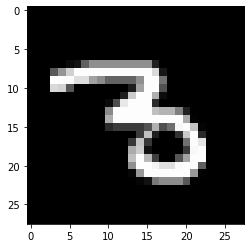

In [4]:
# load MNIST
path = '../MNIST/'   # the training set is stored in this directory

# Train data
fname_train_images = os.path.join(path, 'train-images-idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels-idx1-ubyte')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols)
    
print('The training set contains', len(train_images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', train_images[0].shape)  # print the shape of the image


imgNumber = 30  # choose which image you want to display
print('The label of the image is', train_labels[imgNumber])  # print the label of the image displayed

pyplot.imshow(train_images[imgNumber], cmap='gray')  # plot the image in "gray" colormap
pyplot.show()

In [5]:
# load test set

fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the training set image file path
fname_test_labels = os.path.join(path, 't10k-labels-idx1-ubyte 2')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_test_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    test_y = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    test_X = np.fromfile(fimg, dtype=np.uint8).reshape(len(test_y), rows, cols)
    
print('The training set contains', len(test_X), 'images')  # print the how many images contained in the training set
print('The shape of the image is', test_X[0].shape)  # print the shape of the image

The training set contains 10000 images
The shape of the image is (28, 28)


## Preprocessing

Flatten. Typically, pictures are reshaped to column vectors. The images in the dataset are of size (28,28)
 and should be reshaped to column vectors of size (28x28,1).

In [6]:
train_X = np.reshape(train_images, (train_images.shape[0], -1))
train_X = train_X.T
train_X.shape

(784, 60000)

In [7]:
# set y as boolean: 4 or not 4
train_y = train_labels == 4
train_y.shape

(60000,)

In [8]:
# preprocess test set
test_X = np.reshape(test_X, (test_X.shape[0], -1))
test_X = test_X.T
test_X.shape

(784, 10000)

In [9]:
test_y = test_y == 4

For scaling of picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [10]:
train_X = train_X / 255
test_X = test_X / 255

The training data set contains 60,000 examples. Create smaller training datasets for development and validation. Investigate the impact of the training data size.

In [11]:
# # shuffle the samples to select randomly

# c = list(zip(train_X, train_labels))
# random.shuffle(c)
# train_X, train_y = zip(*c)

num_s = int(train_X.shape[1] * 0.3)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
val_Xs = train_X[:,num_s:] 

train_Xs.shape

(784, 18000)

## Learning

    • Use vectorized implementation.
    • Plot the learning curve (cost function vs. number of iterations).
    • Investigate the impact of the learning rate.

forward prop: 
$$ z^{[1]} = W^{[1]} X + b^{[1]} \\
a^{[1]} = g^{[1]}(z^{[1]}) \\$$
$$z^{[l]} = W^{[l]} a^{[1-1]} + b^{[l]} \\ 
a^{[l]} = g(z^{[l]}) $$
last layer:
$$A^{[L]} = sigma(z^{[L]}) = \frac{1}{1 + e^{-(W^{[L]} a^{[L-1]} + b^{[L]})}} $$
 where $g(\cdot)$ is non-linear activation function such as Relu( ) or tanh( ).
 
Loss function:
$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{[L](i)})+(1-y^{(i)})\log(1-a^{[L](i)})$$


Back Prop for last layer:

$$ dz^{[L]} = A^{[L]} - Y \\
dW^{[L]} = \frac{1}{m} dz^{[L]} A^{[L-1]T}\\
db^{[L]} = \frac{1}{m} sum(dz^{[L]}) \\ \\
da^{[L-1]} = W^{[L]T} dz^{[L]} 
$$

Back Prop for middle layer:

$$ dz^{[l]} = da^{[l]}* g^{[l]'}(z^{[l]}) \\
dW^{[l]} = \frac{1}{m} dz^{[l]} A^{[l-1]T} \\
db^{[l]} = \frac{1}{m} sum(dz^{[l]}) \\
da^{[l-1]} = W^{[l]T} dz^{[l]} 
$$

where $dw$ is short-hand note for $\frac{\partial J}{\partial w} $. $*$ is pointwise manipulator.

In [25]:
# define layers    
class linear_layer(object):    
    '''
    implement z = WX + b
    '''
    def __init__(self, in_dim, out_dim, step_size = 0.1):
        '''
        in_dim - input dimension, feature dimention of X
        out_dim - output dimension, feature dimention of z
        step_size - update step size for gradient discent
        '''
        self.in_dim = in_dim
        self.out_dim = out_dim
        ## random initiate parameters, sample from normal disrtibution
        self.W = np.random.randn(self.out_dim, self.in_dim)*0.1
        self.b = np.random.randn(self.out_dim, 1)*0.1
#         self.b = np.zeros((self.out_dim, 1))
        self.step = step_size
        
    def forward_prop(self, X):
        '''
        input:X
        output: z
        '''
        self.m = X.shape[1] # number of samples 
        return np.dot(self.W, X) + self.b
    
    def backward_prop(self, dz, X):   
        '''
        calculate the derivative of W and b
        dz - derivative of output
        X - input
        '''
        # dz: gradient of output
        # X : input
        self.dW = np.dot(dz, X.T) / self.m 
        self.db = np.sum(dz) / self.m 
        # gradient of the input (last layer activation)
        da = np.dot(self.W.T, dz)
        return da
        
    def update(self):
        '''
        update weights and bias according to stored gradient
        '''
        self.W -= self.step * self.dW
        self.b -= self.step * self.db

class logistic_regression_head(object):
    '''
        z = WX + b
        A = sigmoid(z)
        output layer of this binary classification problem.
        take the last hidden layer as input and output a single prediction value.
    '''
    def __init__(self, in_dim, step_size):
        '''
        in_dim - input dimension
        out_dim is 1
        step_size - update step size for gradient discent
        '''
        ## random initiate parameters, sample from normal disrtibution
        self.step = step_size
        self.w = np.random.randn(1, in_dim) 
        self.b = np.random.randn() 
        
    def forward_prop(self, X):
        '''
        input: X
        output: A
        '''
        self.m = X.shape[1] # number of samples 
        self.z = np.dot(self.w, X) + self.b
        self.A = sigmoid(self.z)  # shape(1, m)
        return self.A
        
    def backward_prop(self, dz, X):
        '''
        calculate the derivative of W and b, output the derivative of input X
        input:
        dz - derivative of output
        X - input
        output:
        dx - derivative of input
        '''
        ## gradient of weights
        self.dw = np.dot(dz, X.T) / self.m
        self.db = np.sum(dz) / self.m 
        ## gradient of input
        dx = np.dot(self.w.T, dz)
        return dx
        
    def update(self):
        '''
        update weights and bias according to stored gradient
        '''
        self.w -= self.step * self.dw
        self.b -= self.step * self.db
        

## define functions
def sigmoid(z):
    return 1/(1+ np.exp(-z))

def cross_entropy_cost(A, y):
    '''
    A: prediction; 
    y: true value
    '''      
    m = len(y) # number of samples
    return -(np.dot(np.log(A), y.T) + np.dot(np.log(1 - A), (1 - y.T)))/m

def relu(z):
    return np.maximum(z, 0)

def grad_relu(z):
    '''
    gradient of relu given input z 
    a = relu(z)
    z: input
    '''
#     dz = np.array(da, copy = True)
    dz = np.ones_like(z)
    dz[z <= 0] = 0
    return dz
   
def grad_tanh(a):
    '''
    gradient of tanh given (input z or) gradient of output a
    a = tanh(z)
    '''
    dz = 1 - np.square(a)
    return dz

In [26]:
# define model
class deep_feedforward_network(object):
    def __init__(self, X_train, y_train, hidden_features, number_layers, activation = 'reLu', step_size = 0.1, max_iter = 1000,tol = 1e-2, random_seed = 0, verbal = True):
        '''
        Use ReLU in the hidden layers and sigmoid in the output layer.
        number_layers: number of hidden layers, at least 1
        '''  
        self.verbal = verbal
        self.seed = random_seed
        np.random.seed(self.seed)
        self.step = step_size
        self.tol = tol
        self.activation = activation
        self.max_iter = max_iter
        self.X = X_train
        self.y = y_train
        self.n0 = X_train.shape[0] # input feature size
        self.m = X_train.shape[1] # number of samples
        self.n1 = hidden_features # hidden feature size
        self.number_layers = number_layers
        
        # LAYERS
        self.layers = []
        # first hidden layer
        self.layers.append(linear_layer(self.n0, self.n1, self.step)) 
        # middle layers
        for i in range(self.number_layers - 1):
            self.layers.append(linear_layer(self.n1, self.n1, self.step))
        # output layer
        self.output_layer = logistic_regression_head(self.n1, self.step)    
        
        
    ### training functions #####
    def forward_prop(self, X, eval = False):
        '''Given training data A, forward propogate though all layers and output prediction value
        X - input
        eval - in evaluation mode or not. training mode would need more storage space for back prop.
        '''
        if not eval:
            # in training mode, store intermediate variables for back prop
            self.zi = []
            self.ai = []
            a = X
            self.ai.append(a)
            for i in range(self.number_layers):
                layer = self.layers[i]
                z = layer.forward_prop(a)
                if self.activation == 'tanh':
                    a = np.tanh(z)
                else:
                    a = relu(z)
                self.zi.append(z)
                self.ai.append(a)
            self.aL = self.output_layer.forward_prop(a)
            return self.aL
        else:
            # in evaluatation mode, do not store variables 
            a = X
            for i in range(self.number_layers):
                layer = self.layers[i]
                z = layer.forward_prop(a)
                if self.activation == 'tanh':
                    a = np.tanh(z)
                else:
                    a = relu(z)
            self.aL = self.output_layer.forward_prop(a)
            return self.aL
    
    def backward_prop(self):
        '''
        backward propogation, store gradients in the process
        '''
        dzL = self.aL - self.y
        da = self.output_layer.backward_prop(dzL, self.ai[-1])
        for i in range(self.number_layers):
            z = self.zi[-1-i]
            a = self.ai[-2-i]
            if self.activation == 'tanh':
                dz = np.multiply(da, grad_tanh(a))
            else:  # self.activation == 'reLu':
                dz = np.multiply(da, grad_relu(z))
            layer = self.layers[-1-i]
            da = layer.backward_prop(dz, a)
    
    def update(self):
        '''
        update weights based on stored gradients.
        '''
        self.output_layer.update()
        for i in range(self.number_layers):
            layer = self.layers[-1-i]
            layer.update()
                       
    def fit(self):
        '''
        wrap forward prop, back prop and update, fit the data. record the cost vs. iteration
        '''
        self.costs = np.zeros(self.max_iter) # record costs
        self.costs[:] = np.nan
        for i in range(self.max_iter):
            A = self.forward_prop(self.X)
            self.costs[i] = cross_entropy_cost(A, self.y)
            self.backward_prop()
            self.update()
            
            if i % 100 == 0 and self.verbal:
                print("Cost after iteration %i : %f" %(i, self.costs[i]))
                
            if self.costs[i] < self.tol:
                print("Cost less than %e after iteration %i : %f" %(self.tol, i, self.costs[i]))
                break
                
    def plot_curve(self):
        '''
        plot cost v.s. iteration curve
        '''
        plt.plot(self.costs)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.title('learning rate: ' + str(self.step))
        plt.show()
        
    ### testing function ###
    def predict(self, X_test):
        '''
        predict the lable of datapoint X_test
        X_test - test data
        output:
        label, 0 or 1
        '''
        # if sigmoid value >= 0.5, possitive
        A = self.forward_prop(X_test, eval = False)
        return A >= 0.5
    
    def evaluate(self, test_X, test_y):
        '''
        evaluate the performance of the model given a test set
        test_X - test set features
        test_y - test set labels
        output: print accuracy and F1 socre of model prediction, 
                alse print training accuracy and F1 socre as comparison.
        '''
        # training score
        train_y_pred = self.predict(self.X).flatten()
        train_acc = accuracy_score(self.y, train_y_pred)
        train_f1 = f1_score(self.y, train_y_pred)
        print("Training accuracy: %.3f   F1 score: %.3f" %(train_acc, train_f1))
        # testing score
        test_y_pred = self.predict(test_X).flatten()
        test_acc = accuracy_score(test_y_pred, test_y)
        test_f1 = f1_score(test_y_pred, test_y)
        print("Testing accuracy: %.3f    F1 score: %.3f" %(test_acc, test_f1))    

In [27]:
step = 0.1
NN = deep_feedforward_network(train_Xs, train_ys,hidden_features = 5, number_layers=2, step_size = step, max_iter = 500, verbal = True)
NN.fit()

Cost after iteration 0 : 0.408497
Cost after iteration 100 : 0.203022
Cost after iteration 200 : 0.097616
Cost after iteration 300 : 0.072877
Cost after iteration 400 : 0.064937


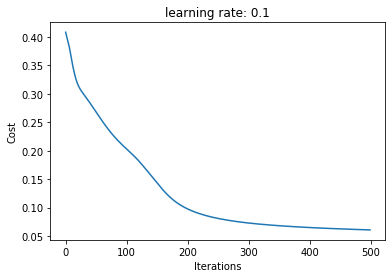

In [28]:
NN.plot_curve()

## Evaluation

    • Compute the training and the test error.
    • Try test examples.

In [29]:
NN.evaluate(test_X, test_y)

Training accuracy: 0.980   F1 score: 0.894
Testing accuracy: 0.979    F1 score: 0.888


The result shows that using 30% training sample, two hidden layer can result in pretty good performance. Also, using smaller initial value results in better performance.

## Infulence of size of traing data

In [15]:
import time
for portion in [0.3, 0.6, 1]:
    # use just portion of data
    num_s = int(train_X.shape[1] * portion)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    NN = deep_feedforward_network(train_Xs, train_ys,hidden_features = 5, number_layers=2, step_size = step, max_iter = 1000, verbal = False)
    # time the training process
    tic = time.clock()
    NN.fit()
    fitT = time.clock() - tic
    print("Using %.2f of training data, %d samples in toal, training took %.2f seconds" %(portion, num_s, fitT))
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

Using 0.30 of training data, 18000 samples in toal, training took 104.42 seconds
Training accuracy: 0.985   F1 score: 0.921
Testing accuracy: 0.982    F1 score: 0.904
---------------
Using 0.60 of training data, 36000 samples in toal, training took 213.93 seconds
Training accuracy: 0.984   F1 score: 0.914
Testing accuracy: 0.981    F1 score: 0.904
---------------
Using 1.00 of training data, 60000 samples in toal, training took 357.85 seconds
Training accuracy: 0.983   F1 score: 0.912
Testing accuracy: 0.983    F1 score: 0.910
---------------


We can see that a small portion of the total training data (30%) can already achieve good results with significantly less time. Meanwhile, using less data samples, the training F1 score is higher, but the testing F1 score is lower. This shows that overfitting might be happening with less data samples, leading to less generalization abilities.

## Influence of learning rate

In [16]:
# use 50% of training data
num_s = int(train_X.shape[1] * 0.5)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
Tcosts = []
for step in [0.5, 0.05, 0.01]:
    NN = deep_feedforward_network(train_Xs, train_ys,hidden_features = 5, number_layers=2, step_size = step, max_iter = 500, verbal = False)
    print("step size: %.2f" %(step))
    NN.fit()
    NN.evaluate(test_X, test_y)
    # record the cost curve
    Tcosts.append(NN.costs)
    print('---------------')

step size: 0.50
Training accuracy: 0.985   F1 score: 0.923
Testing accuracy: 0.982    F1 score: 0.909
---------------
step size: 0.05
Training accuracy: 0.978   F1 score: 0.883
Testing accuracy: 0.976    F1 score: 0.870
---------------
step size: 0.01
Training accuracy: 0.902   F1 score: 0.000
Testing accuracy: 0.902    F1 score: 0.000
---------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


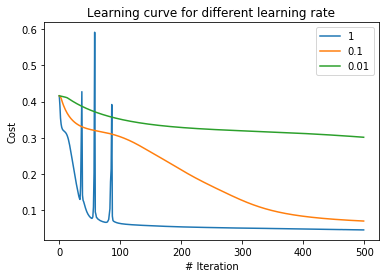

In [17]:
for cost in Tcosts:
    plt.plot(cost)
plt.xlabel('# Iteration')
plt.ylabel('Cost')
plt.legend(("1", "0.1", "0.01"))
plt.title("Learning curve for different learning rate" )
plt.show()

We can see from the result that choosing learning rate is crucial to get good results. in this case using step size too small it could not converge to optimal solution in time. And using step size too large the learning curve has several spikes, suffering from overshoot during training.

## Number of hidden units

In [18]:
for hidden_dim in [5, 10, 20]:
    # use just portion of data
    num_s = int(train_X.shape[1] * 0.6)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    NN = deep_feedforward_network(train_Xs, train_ys, hidden_features = hidden_dim, number_layers=2, step_size = 0.1, max_iter = 500, verbal = False)
    # time the training process
    tic = time.clock()
    NN.fit()
    fitT = time.clock() - tic
    print("Using %d hidden units, training took %.2f seconds" %(hidden_dim, fitT))
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

Using 5 hidden units, training took 108.40 seconds
Training accuracy: 0.982   F1 score: 0.904
Testing accuracy: 0.980    F1 score: 0.898
---------------
Using 10 hidden units, training took 126.38 seconds
Training accuracy: 0.983   F1 score: 0.911
Testing accuracy: 0.981    F1 score: 0.904
---------------
Using 20 hidden units, training took 132.33 seconds
Training accuracy: 0.903   F1 score: 0.000
Testing accuracy: 0.902    F1 score: 0.000
---------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


We can see that increasing units will first improve the performance, but when hidden dimension is too large it becomes to hard to train, and the network predicts everything as negative.

In terms of time, using more features will result in longer time, but the increase is sublinear with respect to number of hidden units. This shows the efficiency of vectorized implementations.

## Number of hidden layers

In [33]:
for n_hidden_layer in [2, 3, 4]:
    # use just portion of data
    num_s = int(train_X.shape[1] * 0.3)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    NN = deep_feedforward_network(train_Xs, train_ys, hidden_features = 5, number_layers= n_hidden_layer, step_size = 0.5, max_iter = 1000, verbal = False)
    # time the training process
    tic = time.clock()
    NN.fit()
    fitT = time.clock() - tic
    print("Using %d hidden layers, training took %.2f seconds" %(n_hidden_layer, fitT))
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

Using 2 hidden layers, training took 108.24 seconds
Training accuracy: 0.991   F1 score: 0.951
Testing accuracy: 0.985    F1 score: 0.921
---------------
Using 3 hidden layers, training took 110.99 seconds
Training accuracy: 0.982   F1 score: 0.903
Testing accuracy: 0.976    F1 score: 0.866
---------------
Using 4 hidden layers, training took 114.07 seconds
Training accuracy: 0.903   F1 score: 0.000
Testing accuracy: 0.902    F1 score: 0.000
---------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


We can see that using more hidden layers actually decreases the performance, making it harder to train. The largest depth this fully connected network can reach is 3 hidden layers.

## Type of activation function

In [37]:
for activ in ['relu', 'tanh']:
    NN = deep_feedforward_network(train_Xs, train_ys,hidden_features = 5,number_layers = 2, activation= activ, step_size = 0.5, max_iter = 1000, verbal = False)
    # time the training process
    NN.fit()
    print("Activation function: ", activ )
    # evaluate
    NN.evaluate(test_X, test_y)
    print('---------------')

Activation function:  relu
Training accuracy: 0.991   F1 score: 0.951
Testing accuracy: 0.985    F1 score: 0.921
---------------
Activation function:  tanh
Training accuracy: 0.959   F1 score: 0.742
Testing accuracy: 0.958    F1 score: 0.733
---------------


We can see that using relu will result in better performance

## Example of miss-classified image

In [20]:
NN = deep_feedforward_network(train_Xs, train_ys,hidden_features = 10, number_layers=2, step_size = 0.1, max_iter = 500, verbal = False)
NN.fit()

In [21]:
miss_classified = test_X[:, NN.predict(test_X).flatten() != test_y]

In [22]:
miss_classified.shape

(784, 982)

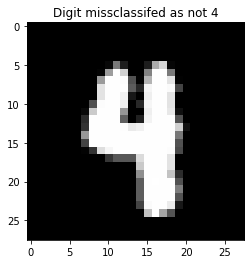

In [26]:
sample = miss_classified[:, 33] * 255
sample = np.reshape(sample, [28,28])
pyplot.imshow(sample, cmap='gray')  # plot the image in "gray" colormap
pyplot.title("Digit missclassifed as not 4")
pyplot.show()